<a href="https://colab.research.google.com/github/smartdesignlab/SDL_teaching/blob/main/KAIST_SDL_3_Optimization_AI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **3. Multi-Objective Optimization with Generative AI (DDIM) & Predictive AI (CNN) via NSGA-2**

![](https://drive.google.com/uc?id=1IDICtMIUyU0ESoKNUOWMSZkiFVyuNZ51)

- A **pre-trained CNN model** that predicts two compliance values (objectives).
- A **pre-trained UNet model** with a DDIM scheduler for image generation.

**Overview**:
1) Import libraries and set up environment.
2) Load pre-trained models (CNN predictor & DDIM-based UNet).
3) Generate structures from noise using DDIM.
4) Predict compliance values with CNN.
5) Optimize using NSGA-2.
6) Visualize and save results.

## 1) Import Libraries and Environment Setup

### **| Load Pre-trained model**

In [1]:
# 생성모델로 설계안 생성 → 예측모델로 성능 빠르게 추정 → 좋은 해만 고비용 평가(FEA)
# - surrogate(대리모델)를 쓰면 최적화 반복 중 평가 시간을 크게 줄일 수 있습니다.
predictor_path = './Predictor_resnet34.pth'
generator_path = './Generator_DDIM.pth'

!gdown 1bJPjeApDOnpEBRGObd256EBbwz3tLq1u -O {predictor_path}
!gdown 1ZjH4sgYuOREx9sKJk0O3ARckcjVycD1D -O {generator_path}

!ls -lh {predictor_path}
!ls -lh {generator_path}

Downloading...
From (original): https://drive.google.com/uc?id=1bJPjeApDOnpEBRGObd256EBbwz3tLq1u
From (redirected): https://drive.google.com/uc?id=1bJPjeApDOnpEBRGObd256EBbwz3tLq1u&confirm=t&uuid=4af98c23-3564-455e-a544-c4366040e042
To: /content/Predictor_resnet34.pth
100% 85.5M/85.5M [00:01<00:00, 74.0MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1ZjH4sgYuOREx9sKJk0O3ARckcjVycD1D
From (redirected): https://drive.google.com/uc?id=1ZjH4sgYuOREx9sKJk0O3ARckcjVycD1D&confirm=t&uuid=b144b8f2-5c7a-4740-bab6-143b7dd2c2b9
To: /content/Generator_DDIM.pth
100% 176M/176M [00:03<00:00, 51.8MB/s]
-rw-r--r-- 1 root root 82M Feb 22 15:14 ./Predictor_resnet34.pth
-rw-r--r-- 1 root root 168M Feb 22 15:14 ./Generator_DDIM.pth


In [2]:
!pip install deap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 136.0/136.0 kB 6.3 MB/s eta 0:00:00


### **| Import python libraries**

In [3]:
import os
import csv
import torch
import torch.nn as nn
import torchvision.models as models
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import random
import time
import math
from deap import base, creator, tools
from diffusers import DDIMScheduler
from diffusers.models import UNet2DModel

# For inline image display (optional)
from IPython.display import Image as DispImage, display

# Use GPU if available
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print("PyTorch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
print("Device in use:", device)

USE_DENORM = True

compliance_min = torch.tensor([29.07, 11.95], dtype=torch.float32, device=device)
compliance_max = torch.tensor([189.90, 191.65], dtype=torch.float32, device=device)

def set_seed(seed=42):
    """Fix random seeds for reproducibility."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

def sigmoid_filter(image: np.ndarray, alpha: float = 10.0):
    image = (image + 1.0) / 2.0  # [-1, 1] → [0, 1]
    contrasted = 1 / (1 + np.exp(-alpha * (image - 0.5)))
    contrasted = (contrasted * 255).clip(0, 255).astype(np.uint8)
    return contrasted

Flax classes are deprecated and will be removed in Diffusers v1.0.0. We recommend migrating to PyTorch classes or pinning your version of Diffusers.
Flax classes are deprecated and will be removed in Diffusers v1.0.0. We recommend migrating to PyTorch classes or pinning your version of Diffusers.


PyTorch version: 2.10.0+cu128
CUDA available: True
Device in use: cuda:0


## 2) Load the Pre-trained CNN Predictor
Our CNN model takes a **56x56** grayscale image as input and outputs two compliance values, `(Comp1, Comp2)`. The model is loaded from a saved `.pth` file. Adjust the checkpoint path as needed.

In [4]:
model_name = "resnet34"
def modify_first_conv_to_1ch(model, model_name: str):
    if model_name in ["resnet18", "resnet34", "resnet50"]:
        old_conv = model.conv1
        new_conv = nn.Conv2d(
            in_channels=1,
            out_channels=old_conv.out_channels,
            kernel_size=old_conv.kernel_size,
            stride=old_conv.stride,
            padding=old_conv.padding,
            bias=(old_conv.bias is not None),
        )
        with torch.no_grad():
            new_conv.weight = nn.Parameter(old_conv.weight.mean(dim=1, keepdim=True))
            if old_conv.bias is not None:
                new_conv.bias = old_conv.bias
        model.conv1 = new_conv

    elif model_name in ["efficientnet_b0", "efficientnet_b1"]:
        old_conv = model.features[0][0]
        new_conv = nn.Conv2d(
            in_channels=1,
            out_channels=old_conv.out_channels,
            kernel_size=old_conv.kernel_size,
            stride=old_conv.stride,
            padding=old_conv.padding,
            bias=(old_conv.bias is not None),
        )
        with torch.no_grad():
            new_conv.weight = nn.Parameter(old_conv.weight.mean(dim=1, keepdim=True))
            if old_conv.bias is not None:
                new_conv.bias = old_conv.bias
        model.features[0][0] = new_conv

    else:
        raise ValueError(f"Unsupported model_name: {model_name}")
    return model

def get_pretrained_regressor(model_name="resnet18", num_outputs=2, pretrained=True):
    if model_name == "resnet18":
        weights = models.ResNet18_Weights.IMAGENET1K_V1 if pretrained else None
        model = models.resnet18(weights=weights)
        model = modify_first_conv_to_1ch(model, model_name)
        in_feat = model.fc.in_features
        model.fc = nn.Sequential(
            nn.Dropout(0.3),
            nn.Linear(in_feat, 128),
            nn.ReLU(),
            nn.Linear(128, num_outputs),
        )

    elif model_name == "resnet34":
        weights = models.ResNet34_Weights.IMAGENET1K_V1 if pretrained else None
        model = models.resnet34(weights=weights)
        model = modify_first_conv_to_1ch(model, model_name)
        in_feat = model.fc.in_features
        model.fc = nn.Sequential(
            nn.Dropout(0.3),
            nn.Linear(in_feat, 128),
            nn.ReLU(),
            nn.Linear(128, num_outputs),
        )

    elif model_name == "resnet50":
        weights = models.ResNet50_Weights.IMAGENET1K_V1 if pretrained else None
        model = models.resnet50(weights=weights)
        model = modify_first_conv_to_1ch(model, model_name)
        in_feat = model.fc.in_features
        model.fc = nn.Sequential(
            nn.Dropout(0.3),
            nn.Linear(in_feat, 256),
            nn.ReLU(),
            nn.Linear(256, num_outputs),
        )

    elif model_name == "efficientnet_b0":
        weights = models.EfficientNet_B0_Weights.IMAGENET1K_V1 if pretrained else None
        model = models.efficientnet_b0(weights=weights)
        model = modify_first_conv_to_1ch(model, model_name)
        in_feat = model.classifier[1].in_features
        model.classifier = nn.Sequential(
            nn.Dropout(0.3),
            nn.Linear(in_feat, 128),
            nn.ReLU(),
            nn.Linear(128, num_outputs),
        )

    elif model_name == "efficientnet_b1":
        weights = models.EfficientNet_B1_Weights.IMAGENET1K_V1 if pretrained else None
        model = models.efficientnet_b1(weights=weights)
        model = modify_first_conv_to_1ch(model, model_name)
        in_feat = model.classifier[1].in_features
        model.classifier = nn.Sequential(
            nn.Dropout(0.3),
            nn.Linear(in_feat, 128),
            nn.ReLU(),
            nn.Linear(128, num_outputs),
        )

    else:
        raise ValueError("model_name must be one of: resnet18/resnet34/resnet50/efficientnet_b0/efficientnet_b1")

    return model
predictor = get_pretrained_regressor(model_name=model_name, num_outputs=2, pretrained=False)
predictor = predictor.to(device)

if os.path.exists(predictor_path):
    predictor.load_state_dict(torch.load(predictor_path, map_location=device))
    predictor.eval()
    print(f"Loaded compliance predictor ({model_name}) from {predictor_path}")
else:
    raise FileNotFoundError(f"Predictor file not found at {predictor_path}")

Loaded compliance predictor (resnet34) from ./Predictor_resnet34.pth


## 3) Load the Pre-trained UNet (DDIM)
We load our DDIM-based generator (`UNet2DModel`) for reverse diffusion from noise to final structure. The scheduler is initialized using `DDIMScheduler`.

In [5]:
# Diffusion settings
num_inference_steps = 50
eta = 0.0

# 불러오기 the UNet 모델
unet = UNet2DModel(
    sample_size=56,
    in_channels=1,
    out_channels=1,
    layers_per_block=1,
    block_out_channels=[64, 128, 256, 512],
).to(device)

if os.path.exists(generator_path):
    unet.load_state_dict(torch.load(generator_path, map_location=device))
    print(f"Model loaded from {generator_path}")
else:
    raise FileNotFoundError(f"Model file not found at {generator_path}")

# 초기화 the DDIM scheduler
scheduler = DDIMScheduler(num_train_timesteps=600)
scheduler.set_timesteps(num_inference_steps, eta)

Model loaded from ./Generator_DDIM.pth


## 4) Generation from Noise
Given an input noise (size 56x56, range [-1,1]), we perform reverse diffusion steps to obtain the final structure via the UNet + DDIM.

In [6]:
@torch.no_grad()
def generate_image_from_noise(noise: torch.Tensor) -> torch.Tensor:
    """
    noise: shape (1, 1, 56, 56)
    return: generated image (1, 1, 56, 56)
    """
    start_time = time.time()

    for t in scheduler.timesteps:
        t_tensor = torch.tensor(t, dtype=torch.long).to(device)
        model_output = unet(noise, t_tensor).sample  # (B, 1, 56, 56)
        noise = scheduler.step(model_output, t_tensor, noise).prev_sample

    end_time = time.time()
    elapsed_time = end_time - start_time
    return noise.clamp(-1.0, 1.0)

## 5) Evaluate Compliance via CNN
The **evaluate_compliance** function:
1. Converts a noise vector into a 2D noise tensor.
2. Generates an image from noise using the UNet.
3. Passes the generated image to our CNN `predictor`.
4. Returns two compliance values `(comp1, comp2)`.

In [7]:
@torch.no_grad()
def evaluate_compliance(noise_vector: np.ndarray):
    """
    Maps a noise vector to two compliance values via UNet + CNN.
    """
    # 1) 노이즈 Vector -> Tensor
    noise_tensor = torch.from_numpy(noise_vector).float().view(1, 1, 56, 56).to(device)

    # 2) 생성 image via DDIM
    gen_image = generate_image_from_noise(noise_tensor)  # (1,1,56,56)

    # 3) Predict 컴플라이언스
    comp_pred = predictor(gen_image)  # shape (1,2)
    comp1_norm, comp2_norm = comp_pred[0, 0].item(), comp_pred[0, 1].item()

    # 4) Denormalize (example scaling)
    if USE_DENORM:
        comp = torch.tensor([comp1_norm, comp2_norm], device=device)
        comp_denorm = comp * (compliance_max - compliance_min) + compliance_min
        comp1, comp2 = float(comp_denorm[0].item()), float(comp_denorm[1].item())
    else:
        # keep normalized scale
        comp1, comp2 = comp1_norm, comp2_norm

    return (comp1, comp2)

## 6) NSGA-2
Below is the setup for our multi-objective optimization:
1. **FitnessMin** (two objectives to minimize: compliance1, compliance2).
2. **Individual** defined as a NumPy array of shape (56x56=3136,).
3. Operators:
   - **init_ind**: Random uniform initialization in [-1,1].
   - **evaluate_compliance**: Our objective function.
   - **mate**: We use `tools.cxBlend`.
   - **mutate**: Gaussian mutation (`tools.mutGaussian`).
4. **select**: We use NSGA-2 (`tools.selNSGA2`).

### **| Define Fitness, Individuals, and Toolbox python**

In [8]:
# NSGA-2 파라미터
pop_size = 100
n_gen = 2
cxpb = 0.7
mutpb = 0.5
sigma = 0.3
eval_batch_size = 32

# 1) Fitness and Individual definitions
creator.create("FitnessMin", base.Fitness, weights=(-1.0, -1.0))
creator.create("Individual", np.ndarray, fitness=creator.FitnessMin)
toolbox = base.Toolbox()

# 2) Initialization function
def init_ind(icls):
    array = np.random.uniform(-1, 1, size=(56*56,))
    return icls(array)

toolbox.register("individual", init_ind, creator.Individual)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)


### **| Initialize and Evaluate Population**

In [9]:
@torch.no_grad()
def evaluate_population(population):
    invalid_ind = [ind for ind in population if not ind.fitness.valid]
    if len(invalid_ind) == 0:
        return

    for i in range(0, len(invalid_ind), eval_batch_size):
        batch_inds = invalid_ind[i:i + eval_batch_size]

        # 배치로 묶어서 한번에 생성 + 예측
        noise_batch = torch.stack([
            torch.from_numpy(np.array(ind)).float().view(1, 56, 56)
            for ind in batch_inds
        ]).to(device)  # (B, 1, 56, 56)

        # DDIM 배치 생성
        images = noise_batch.clone()
        for t in scheduler.timesteps:
            t_tensor = torch.full((images.shape[0],), int(t), dtype=torch.long, device=device)
            model_output = unet(images, t_tensor).sample
            images = scheduler.step(model_output, int(t), images).prev_sample
        images = images.clamp(-1.0, 1.0)

        # Predictor 배치 예측
        comp_pred = predictor(images)  # (B, 2)

        if USE_DENORM:
            comp_denorm = comp_pred * (compliance_max - compliance_min) + compliance_min
        else:
            comp_denorm = comp_pred

        # fitness 할당
        for ind, j in zip(batch_inds, range(len(batch_inds))):
            ind.fitness.values = (comp_denorm[j, 0].item(), comp_denorm[j, 1].item())

# 4) Crossover and 변이(mutation) operators
toolbox.register("mate", tools.cxBlend, alpha=0.5)
toolbox.register("mutate", tools.mutGaussian, mu=0.0, sigma=sigma, indpb=0.05)

# 5) NSGA-2 선택(selection)
toolbox.register("select", tools.selNSGA2)

# 1) 생성 initial 개체집단(population)
pop = toolbox.population(n=pop_size)
print(f"Created initial population of size {pop_size}.")

# 2) Evaluate initial 개체집단(population)
evaluate_population(pop)
print("Initial population evaluated.")

Created initial population of size 100.
Initial population evaluated.


/tmp/ipython-input-307302135.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t_tensor = torch.tensor(t, dtype=torch.long).to(device)


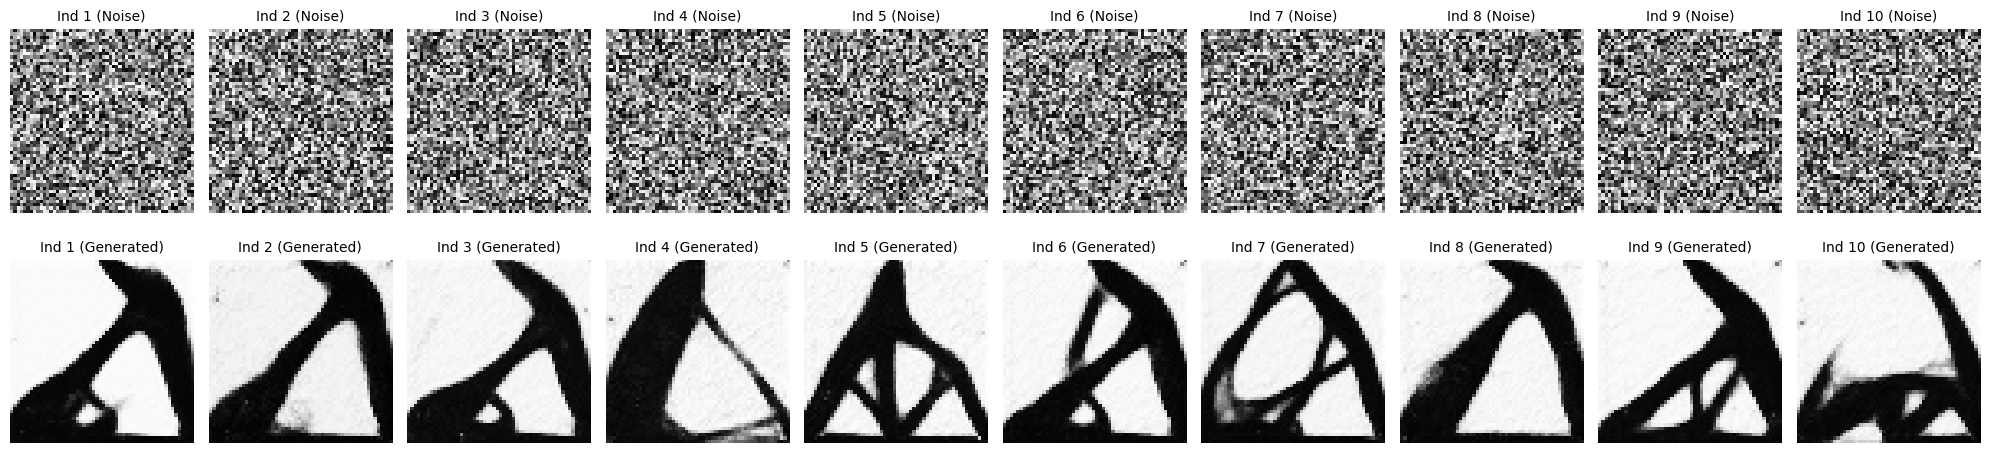

In [10]:
num_samples = min(10, pop_size)
sample_population = pop[:num_samples]

fig, axes = plt.subplots(2, num_samples, figsize=(num_samples * 2, 5))

for i, ind in enumerate(sample_population):
    noise_vector = ind.reshape(56, 56)
    axes[0, i].imshow(noise_vector, cmap="gray", interpolation="nearest")
    axes[0, i].set_title(f"Ind {i+1} (Noise)", fontsize=10)
    axes[0, i].axis("off")

    noise_tensor = torch.from_numpy(ind).float().view(1, 1, 56, 56).to(device)
    gen_image = generate_image_from_noise(noise_tensor)
    img_np = gen_image.squeeze().cpu().numpy()

    filtered_img = sigmoid_filter(img_np)

    axes[1, i].imshow(filtered_img, cmap="gray", interpolation="nearest")
    axes[1, i].set_title(f"Ind {i+1} (Generated)", fontsize=10)
    axes[1, i].axis("off")

plt.tight_layout()
plt.show()

### **| NSGA-2 Evolution**

In [11]:
for gen in range(n_gen):
    print(f"\n-- Generation {gen+1} --")

    # 1) Selection
    offspring = toolbox.select(pop, len(pop))
    offspring = list(map(toolbox.clone, offspring))

    # 2) Crossover
    for i in range(0, len(offspring), 2):
        if random.random() < cxpb and (i + 1) < len(offspring):
            toolbox.mate(offspring[i], offspring[i + 1])
            del offspring[i].fitness.values
            del offspring[i + 1].fitness.values

    # 3) Mutation
    for mutant in offspring:
        if random.random() < mutpb:
            toolbox.mutate(mutant)
            del mutant.fitness.values

    evaluate_population(offspring)

    # 5) Combine parent + offspring, select next generation
    combined = pop + offspring
    evaluate_population(combined)  # catch any stragglers
    pop = toolbox.select(combined, pop_size)

    # Print generation results
    fits = [ind.fitness.values for ind in pop]
    for i, f in enumerate(fits):
        print(f"Individual {i} => (comp1={f[0]:.4f}, comp2={f[1]:.4f})")

print("\nOptimization complete!")


-- Generation 1 --
Individual 0 => (comp1=42.5479, comp2=25.8567)
Individual 1 => (comp1=42.5479, comp2=25.8567)
Individual 2 => (comp1=69.9555, comp2=20.3284)
Individual 3 => (comp1=69.9555, comp2=20.3284)
Individual 4 => (comp1=33.7940, comp2=78.7832)
Individual 5 => (comp1=63.0853, comp2=24.3320)
Individual 6 => (comp1=40.1809, comp2=38.9896)
Individual 7 => (comp1=37.7171, comp2=39.7655)
Individual 8 => (comp1=37.7171, comp2=39.7655)
Individual 9 => (comp1=62.9988, comp2=24.3954)
Individual 10 => (comp1=62.9988, comp2=24.3954)
Individual 11 => (comp1=41.0155, comp2=33.4771)
Individual 12 => (comp1=37.3255, comp2=45.9624)
Individual 13 => (comp1=76.5297, comp2=9.6730)
Individual 14 => (comp1=76.5297, comp2=9.6730)
Individual 15 => (comp1=63.3457, comp2=24.2730)
Individual 16 => (comp1=33.9743, comp2=77.6396)
Individual 17 => (comp1=34.2440, comp2=47.8983)
Individual 18 => (comp1=34.0984, comp2=60.0891)
Individual 19 => (comp1=56.7348, comp2=25.0859)
Individual 20 => (comp1=61.3689,

### **| Pareto Front**

In [12]:
fronts = tools.sortNondominated(pop, k=len(pop), first_front_only=True)
pareto_front = fronts[0]
pareto_front_sorted = sorted(pareto_front, key=lambda ind: ind.fitness.values[0])

print(f"Extracted Pareto front with {len(pareto_front_sorted)} individuals.")


Extracted Pareto front with 24 individuals.


### Save Pareto Front to CSV

In [13]:
os.makedirs("final_results", exist_ok=True)
os.makedirs("final_results/solutions", exist_ok=True)

csv_path = os.path.join("final_results", "pareto_front.csv")
with open(csv_path, "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerow(["Index", "Comp1", "Comp2"])
    for i, ind in enumerate(pareto_front_sorted):
        comp1, comp2 = ind.fitness.values
        writer.writerow([i + 1, comp1, comp2])

print(f"Pareto front CSV saved at: {csv_path}")

Pareto front CSV saved at: final_results/pareto_front.csv


### Plot Pareto Front

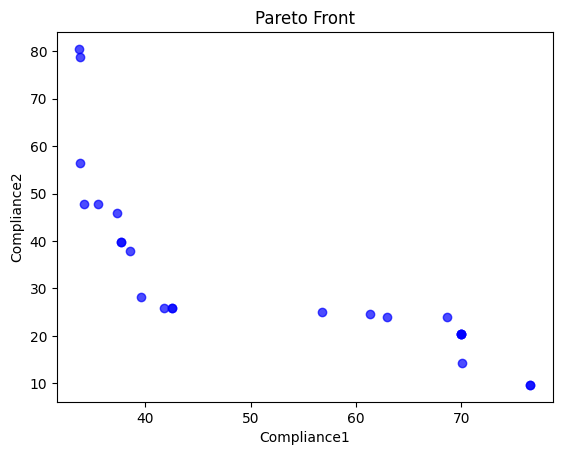

In [14]:
# Plot 파레토(Pareto) Front
comp1_list = [ind.fitness.values[0] for ind in pareto_front]
comp2_list = [ind.fitness.values[1] for ind in pareto_front]

plt.figure()
plt.scatter(comp1_list, comp2_list, c="blue", alpha=0.7)
plt.xlabel("Compliance1")
plt.ylabel("Compliance2")
plt.title("Pareto Front")
plt.show()

### Pareto Solutions

/tmp/ipython-input-307302135.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t_tensor = torch.tensor(t, dtype=torch.long).to(device)


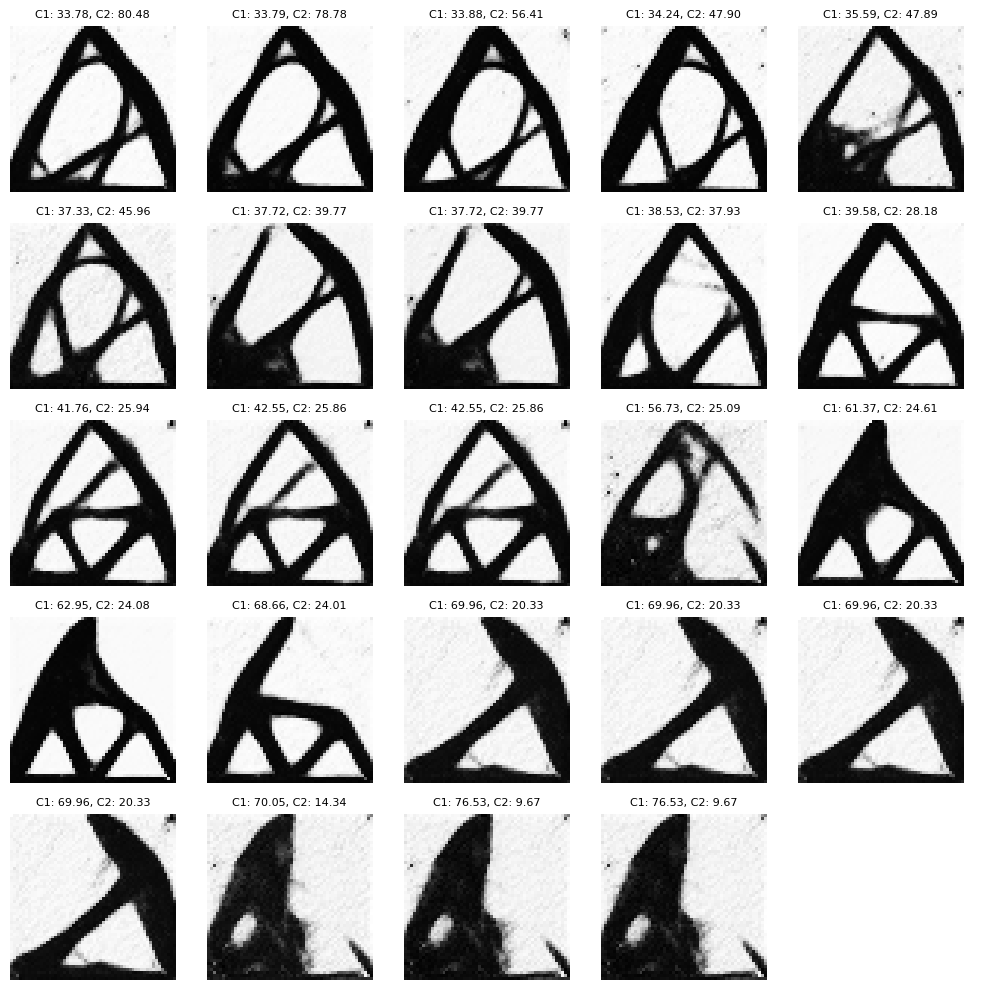

In [15]:
grid_size = math.ceil(math.sqrt(len(pareto_front_sorted)))
fig, axes = plt.subplots(grid_size, grid_size, figsize=(grid_size * 2, grid_size * 2))
axes = axes.flatten()

for idx, ind in enumerate(pareto_front_sorted):
    # 생성 image from 노이즈 using UNet
    noise_vector = torch.from_numpy(ind).float().view(1, 1, 56, 56).to(device)
    gen_image = generate_image_from_noise(noise_vector)
    img_np = gen_image.squeeze().cpu().numpy()

    # Apply sigmoid filter for better contrast
    filtered_img = sigmoid_filter(img_np)

    image_path = os.path.join("final_results/solutions", f"solution_{idx+1}.png")
    plt.imsave(image_path, filtered_img, cmap="gray")

    # Plot the image
    axes[idx].imshow(filtered_img, cmap="gray", interpolation="nearest")
    axes[idx].set_title(f"C1: {ind.fitness.values[0]:.2f}, C2: {ind.fitness.values[1]:.2f}", fontsize=8)
    axes[idx].axis("off")

# Remove empty subplots
for idx in range(len(pareto_front_sorted), len(axes)):
    axes[idx].axis("off")

plt.tight_layout()
plt.show()

## 6) Method B: Conditional DDIM + NSGA-II

In [16]:
!gdown 1VgQzcvOy7PNUIgkImjZrKOToYYB9xqlI -O Generator_cDDIM.pth
!ls -lh Generator_cDDIM.pth

cddim_ckpt = torch.load("Generator_cDDIM.pth", map_location=device)
cddim_ckpt_path = "./Generator_cDDIM.pth"

print("cddim_ckpt_path:", cddim_ckpt_path, "| exists:", os.path.exists(cddim_ckpt_path))

Downloading...
From (original): https://drive.google.com/uc?id=1VgQzcvOy7PNUIgkImjZrKOToYYB9xqlI
From (redirected): https://drive.google.com/uc?id=1VgQzcvOy7PNUIgkImjZrKOToYYB9xqlI&confirm=t&uuid=3e7b0a97-4de5-4840-80cd-4eeef2889db0
To: /content/Generator_cDDIM.pth
100% 195M/195M [00:01<00:00, 131MB/s]
-rw-r--r-- 1 root root 187M Feb 22 15:14 Generator_cDDIM.pth
cddim_ckpt_path: ./Generator_cDDIM.pth | exists: True


In [17]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

# ---- Conditional UNet (from 3_2_Optim_comp.py) ----
class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = np.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings

class ConditionalResBlock(nn.Module):
    def __init__(self, in_channels, out_channels, time_emb_dim, cond_emb_dim):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, padding=1)
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, padding=1)
        self.norm1 = nn.GroupNorm(8, out_channels)
        self.norm2 = nn.GroupNorm(8, out_channels)
        self.time_mlp = nn.Linear(time_emb_dim, out_channels)
        self.cond_mlp = nn.Linear(cond_emb_dim, out_channels)
        self.residual_conv = nn.Conv2d(in_channels, out_channels, 1) if in_channels != out_channels else nn.Identity()

    def forward(self, x, t_emb, c_emb):
        h = self.conv1(x)
        h = self.norm1(h)
        h = h + self.time_mlp(t_emb)[:, :, None, None]
        h = h + self.cond_mlp(c_emb)[:, :, None, None]
        h = F.silu(h)
        h = self.conv2(h)
        h = self.norm2(h)
        h = F.silu(h)
        return h + self.residual_conv(x)

class ConditionalUNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=1, time_emb_dim=256, cond_dim=2, cond_emb_dim=128):
        super().__init__()

        self.time_mlp = nn.Sequential(
            SinusoidalPositionEmbeddings(time_emb_dim),
            nn.Linear(time_emb_dim, time_emb_dim),
            nn.SiLU(),
            nn.Linear(time_emb_dim, time_emb_dim),
        )

        self.cond_mlp = nn.Sequential(
            nn.Linear(cond_dim, cond_emb_dim),
            nn.SiLU(),
            nn.Linear(cond_emb_dim, cond_emb_dim),
            nn.SiLU(),
            nn.Linear(cond_emb_dim, cond_emb_dim),
        )

        self.enc1 = ConditionalResBlock(in_channels, 64, time_emb_dim, cond_emb_dim)
        self.enc2 = ConditionalResBlock(64, 128, time_emb_dim, cond_emb_dim)
        self.enc3 = ConditionalResBlock(128, 256, time_emb_dim, cond_emb_dim)
        self.enc4 = ConditionalResBlock(256, 512, time_emb_dim, cond_emb_dim)

        self.pool = nn.MaxPool2d(2)
        self.bottleneck = ConditionalResBlock(512, 512, time_emb_dim, cond_emb_dim)

        self.up4 = nn.ConvTranspose2d(512, 512, 2, stride=2)
        self.dec4 = ConditionalResBlock(1024, 256, time_emb_dim, cond_emb_dim)

        self.up3 = nn.ConvTranspose2d(256, 256, 2, stride=2)
        self.dec3 = ConditionalResBlock(512, 128, time_emb_dim, cond_emb_dim)

        self.up2 = nn.ConvTranspose2d(128, 128, 2, stride=2)
        self.dec2 = ConditionalResBlock(256, 64, time_emb_dim, cond_emb_dim)

        self.up1 = nn.ConvTranspose2d(64, 64, 2, stride=2)
        self.dec1 = ConditionalResBlock(128, 64, time_emb_dim, cond_emb_dim)

        self.out_conv = nn.Conv2d(64, out_channels, 1)

    def forward(self, x, timestep, condition):
        t_emb = self.time_mlp(timestep.float())
        c_emb = self.cond_mlp(condition)

        e1 = self.enc1(x, t_emb, c_emb)
        e2 = self.enc2(self.pool(e1), t_emb, c_emb)
        e3 = self.enc3(self.pool(e2), t_emb, c_emb)
        e4 = self.enc4(self.pool(e3), t_emb, c_emb)

        b = self.bottleneck(self.pool(e4), t_emb, c_emb)

        d4 = self.up4(b)
        d4 = F.interpolate(d4, size=e4.shape[2:], mode='bilinear', align_corners=False)
        d4 = self.dec4(torch.cat([d4, e4], dim=1), t_emb, c_emb)

        d3 = self.up3(d4)
        d3 = F.interpolate(d3, size=e3.shape[2:], mode='bilinear', align_corners=False)
        d3 = self.dec3(torch.cat([d3, e3], dim=1), t_emb, c_emb)

        d2 = self.up2(d3)
        d2 = F.interpolate(d2, size=e2.shape[2:], mode='bilinear', align_corners=False)
        d2 = self.dec2(torch.cat([d2, e2], dim=1), t_emb, c_emb)

        d1 = self.up1(d2)
        d1 = F.interpolate(d1, size=e1.shape[2:], mode='bilinear', align_corners=False)
        d1 = self.dec1(torch.cat([d1, e1], dim=1), t_emb, c_emb)

        return self.out_conv(d1)


In [18]:
from diffusers import DDIMScheduler
import numpy as np

# ---- Method B wrapper (Conditional DDIM + existing Predictor) ----
class MethodB_ConditionalDDIM:
    def __init__(self, cddim_ckpt_path, predictor, device, num_train_timesteps=600, num_inference_steps=50):
        self.device = device

        ckpt = torch.load(cddim_ckpt_path, map_location=device, weights_only=False)
        self.model = ConditionalUNet(
            in_channels=1, out_channels=1, time_emb_dim=256, cond_dim=2, cond_emb_dim=128
        ).to(device)

        # 체크포인트 formats:
        # - script expects: ckpt['model_state_dict'], ckpt['c1_range'], ckpt['c2_range']
        if isinstance(ckpt, dict) and 'model_state_dict' in ckpt:
            self.model.load_state_dict(ckpt['model_state_dict'])
            self.c1_min, self.c1_max = ckpt.get('c1_range', (0.0, 1.0))
            self.c2_min, self.c2_max = ckpt.get('c2_range', (0.0, 1.0))
        else:
            # fallback: raw state_dict
            self.model.load_state_dict(ckpt)
            self.c1_min, self.c1_max = 0.0, 1.0
            self.c2_min, self.c2_max = 0.0, 1.0

        self.model.eval()

        self.predictor = predictor.to(device)
        self.predictor.eval()

        self.scheduler = DDIMScheduler(num_train_timesteps=num_train_timesteps)
        self.scheduler.set_timesteps(num_inference_steps)

        if 'compliance_min' in globals() and 'compliance_max' in globals():
            self.compliance_min = compliance_min.to(device) if torch.is_tensor(compliance_min) else torch.tensor(compliance_min, device=device)
            self.compliance_max = compliance_max.to(device) if torch.is_tensor(compliance_max) else torch.tensor(compliance_max, device=device)
        else:
            self.compliance_min = None
            self.compliance_max = None

    def normalize_condition(self, c1, c2):
        c1_norm = (c1 - self.c1_min) / (self.c1_max - self.c1_min + 1e-8)
        c2_norm = (c2 - self.c2_min) / (self.c2_max - self.c2_min + 1e-8)
        return float(c1_norm), float(c2_norm)

    @torch.no_grad()
    def generate_batch(self, conditions, noise_batch=None):
        # conditions: (N,2) in [0,1]
        batch_size = conditions.shape[0]
        conditions = conditions.to(self.device)

        if noise_batch is None:
            images = torch.randn((batch_size, 1, 56, 56), device=self.device)
        else:
            images = noise_batch.to(self.device)

        for t in self.scheduler.timesteps:
            t_int = int(t.item()) if torch.is_tensor(t) else int(t)
            timestep = torch.full((batch_size,), t_int, device=self.device, dtype=torch.long)
            noise_pred = self.model(images, timestep, conditions)
            images = self.scheduler.step(noise_pred, t_int, images).prev_sample

        return images.clamp(-1.0, 1.0)

    @torch.no_grad()
    def evaluate_batch(self, condition_vectors):
        # condition_vectors: list of [c1_norm, c2_norm]
        if len(condition_vectors) == 0:
            return []

        conditions = torch.tensor(condition_vectors, dtype=torch.float32, device=self.device)
        gen_images = self.generate_batch(conditions)

        pred = self.predictor(gen_images)

        # denormalize if ranges exist
        if (self.compliance_min is not None) and (self.compliance_max is not None):
            pred_denorm = pred * (self.compliance_max - self.compliance_min) + self.compliance_min
            return [(pred_denorm[i,0].item(), pred_denorm[i,1].item()) for i in range(len(condition_vectors))]
        else:
            return [(pred[i,0].item(), pred[i,1].item()) for i in range(len(condition_vectors))]

    @torch.no_grad()
    def get_image_from_condition(self, c1_norm, c2_norm):
        condition = torch.tensor([[c1_norm, c2_norm]], dtype=torch.float32, device=self.device)
        img = self.generate_batch(condition)
        return img[0]


In [19]:
from deap import base, creator, tools
import random, time

def run_nsga2_method_b(method_b, pop_size=100, n_gen=50, eval_batch_size=32, seed=42):
    set_seed(seed)

    # clear creators (avoid collision with Method A cells above)
    if hasattr(creator, "FitnessMin"):
        del creator.FitnessMin
    if hasattr(creator, "Individual"):
        del creator.Individual

    creator.create("FitnessMin", base.Fitness, weights=(-1.0, -1.0))
    creator.create("Individual", np.ndarray, fitness=creator.FitnessMin)

    toolbox = base.Toolbox()

    def init_ind():
        # two normalized conditions in [0,1]
        arr = np.random.uniform(0, 1, size=(2,))
        return creator.Individual(arr)

    def evaluate_population(population):
        invalid = [ind for ind in population if not ind.fitness.valid]
        if len(invalid) == 0:
            return
        for i in range(0, len(invalid), eval_batch_size):
            batch = invalid[i:i+eval_batch_size]
            conds = [np.array(ind).tolist() for ind in batch]
            fits = method_b.evaluate_batch(conds)
            for ind, fit in zip(batch, fits):
                ind.fitness.values = fit

    toolbox.register("individual", init_ind)
    toolbox.register("population", tools.initRepeat, list, toolbox.individual)
    toolbox.register("mate", tools.cxBlend, alpha=0.5)
    toolbox.register("mutate", tools.mutGaussian, mu=0.0, sigma=0.1, indpb=0.2)
    toolbox.register("select", tools.selNSGA2)

    pop = toolbox.population(n=pop_size)

    start = time.time()
    evaluate_population(pop)
    print(f"Method B: init eval done in {time.time()-start:.2f}s")

    cxpb, mutpb = 0.7, 0.5
    gen_times=[]
    stats=[]

    for gen in range(n_gen):
        t0=time.time()

        offspring = toolbox.select(pop, len(pop))
        offspring = list(map(toolbox.clone, offspring))

        for i in range(0, len(offspring)-1, 2):
            if random.random() < cxpb:
                toolbox.mate(offspring[i], offspring[i+1])
                del offspring[i].fitness.values
                del offspring[i+1].fitness.values

        for mutant in offspring:
            if random.random() < mutpb:
                toolbox.mutate(mutant)
                mutant[:] = np.clip(mutant, 0, 1)
                del mutant.fitness.values

        evaluate_population(offspring)
        pop = toolbox.select(pop + offspring, pop_size)

        fits=[ind.fitness.values for ind in pop]
        c1=[f[0] for f in fits]; c2=[f[1] for f in fits]
        stats.append((min(c1), float(np.mean(c1)), min(c2), float(np.mean(c2))))
        gen_times.append(time.time()-t0)

        if (gen+1)%10==0 or gen==0:
            print(f"Gen {gen+1:3d}/{n_gen} | C1 min/mean {min(c1):.2f}/{np.mean(c1):.2f} | C2 min/mean {min(c2):.2f}/{np.mean(c2):.2f} | {gen_times[-1]:.2f}s")

    fronts = tools.sortNondominated(pop, k=len(pop), first_front_only=True)
    pareto = sorted(fronts[0], key=lambda ind: ind.fitness.values[0])

    return {"pareto_front": pareto, "gen_times": gen_times, "stats": stats, "pop": pop}


In [20]:
if os.path.exists(cddim_ckpt_path):
    # predictor instance already created above as `predictor`
    method_b = MethodB_ConditionalDDIM(
        cddim_ckpt_path=cddim_ckpt_path,
        predictor=predictor,
        device=device,
        num_train_timesteps=600,
        num_inference_steps=50
    )

    # reuse pop_size/n_gen if they exist above
    pop_size_b = pop_size if 'pop_size' in globals() else 100
    n_gen_b = n_gen if 'n_gen' in globals() else 50

    results_b = run_nsga2_method_b(method_b, pop_size=pop_size_b, n_gen=n_gen_b, eval_batch_size=32, seed=42)
    print("Method B Pareto size:", len(results_b["pareto_front"]))
else:
    results_b = None
    print(f"[Skip] cDDIM checkpoint not found: {cddim_ckpt_path}")


Method B: init eval done in 5.74s
Gen   1/2 | C1 min/mean 31.28/47.43 | C2 min/mean 14.70/34.73 | 4.89s
Method B Pareto size: 49


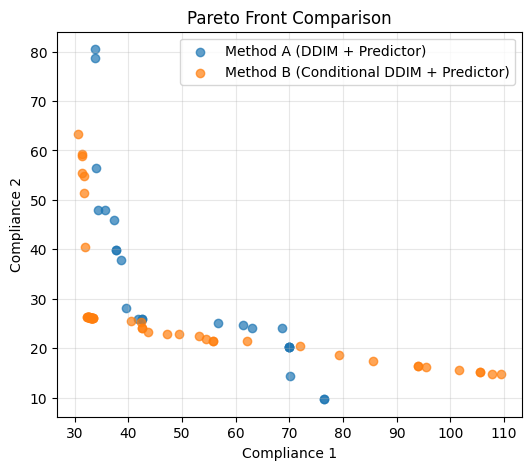

In [21]:
# ---- Compare 파레토(Pareto) fronts (A vs B) ----
import matplotlib.pyplot as plt

plt.figure(figsize=(6,5))

# Method A: already computed above
if 'pareto_front_sorted' in globals() and pareto_front_sorted is not None:
    c1_a = [ind.fitness.values[0] for ind in pareto_front_sorted]
    c2_a = [ind.fitness.values[1] for ind in pareto_front_sorted]
    plt.scatter(c1_a, c2_a, alpha=0.7, label='Method A (DDIM + Predictor)')

# Method B
if results_b is not None:
    pf_b = results_b["pareto_front"]
    c1_b = [ind.fitness.values[0] for ind in pf_b]
    c2_b = [ind.fitness.values[1] for ind in pf_b]
    plt.scatter(c1_b, c2_b, alpha=0.7, label='Method B (Conditional DDIM + Predictor)')

plt.xlabel("Compliance 1")
plt.ylabel("Compliance 2")
plt.title("Pareto Front Comparison")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()
